In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### I/O

In [2]:
FIGURE_SAVEPATH = "../../../figures/"
TYPE1_ERROR_SAVEPATH = "../../../output/type1_errors/"
SAVELABEL = "null_dgps_with_shrink"

SAVE = True

### Formatting

In [3]:
method_cmap = {("Chiseling", 0): "#FF590D",
               ("Chiseling", 1): "#2032DA",
               "DataSplittingStrategy": "#FFBB00",
               "SimulDataSplittingStrategy": "#69C1B9",
               "OracleStrategy": "#000000",
               "OracleSimulStrategy": "#919191",
               "TTestStrategy": "#E70202"}

method_pretty_name_map = {("Chiseling", 0): "NONAME",
                          ("Chiseling", 1): "Chiseling",
                          "DataSplittingStrategy": "Data Splitting",
                          "SimulDataSplittingStrategy": "Simul. Data Splitting",
                          "OracleStrategy": "Oracle",
                          "OracleSimulStrategy": "Simul. Oracle",
                          "TTestStrategy": r"Global $t$-test"}

legend_mapper = {(True, "none", 50): r"Error $\sim$ Binary",
                 (True, "none", 100): r"Error $\sim$ Binary",
                 (True, "none", 150): r"Error $\sim$ Binary",
                 (False, "ipw", 50): r"Error $\sim$ Exponential" + f"\nTransform = IPW",
                 (False, "ipw", 100): r"Error $\sim t_5$" + f"\nTransform = IPW",
                 (False, "ipw", 150): r"Error $\sim$ Heteroskedastic Normal" + f"\nTransform = IPW",
                 (False, "aipw", 50): r"Error $\sim$ Exponential" + f"\nTransform = AIPW",
                 (False, "aipw", 100): r"Error $\sim t_5$" + f"\nTransform = AIPW",
                 (False, "aipw", 150): r"Error $\sim$ Heteroskedastic Normal" + f"\nTransform = AIPW"}

LINEWIDTH = 4

MARKERSIZE = 40
LABEL_FONTSIZE = 24
TITLE_FONTSIZE = 24
LEGEND_FONTSIZE = 22
TICK_FONTSIZE = 17

FACET_FONTSIZE = 23
FACET_TEXTCOLOR = "black"
FACET_FACECOLOR = "grey"
FACET_FACEALPHA = 0.5
FACET_LINEWIDTH = 1.8

alpha = 0.05

### Preprocessing

In [4]:
task_array_path = "../../task_arrays/null_dgps_with_shrink.tasks.tsv"
res_path = "../../../output/null_dgps_with_shrink/null_dgps_with_shrink.combined.tsv"

In [5]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

In [6]:
# Aggregate results
setting_identifiers = ["n", "d", "binary", "cov_type", "err_type",
                       "SPECIAL_TOKEN_NULLDGPS_TRANSFORM_TYPE", "test_thresh", "learner"]
agg_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_res_df.columns = ["_".join(c) for c in agg_res_df.columns.to_flat_index()]
agg_res_df = agg_res_df.reset_index()
agg_res_df["rejected_se"] = np.sqrt(agg_res_df.rejected_var / agg_res_df.rejected_count)
agg_res_df["subgroup_utility_se"] = np.sqrt(agg_res_df.subgroup_utility_var / agg_res_df.subgroup_utility_count)
agg_res_df["region_mass_se"] = np.sqrt(agg_res_df.region_mass_var / agg_res_df.region_mass_count)
agg_res_df = agg_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_se",
                                                     "subgroup_utility_mean", "subgroup_utility_se",
                                                     "region_mass_mean", "region_mass_se"]]

### Settings

In [7]:
d_space = [50, 100, 150]
cov_type_space = ["corrnorm", "binary", "expo"]
err_type_space = ["expo", "t5", "hetnorm"]
learner_space = ["ridgecv_learner", "mlp_regressor_learner", "random_forest_learner"]
binary_transform_type_space = [(True, "none"), (False, "ipw"), (False, "aipw")]

### Visualizations

Type I error (binary)

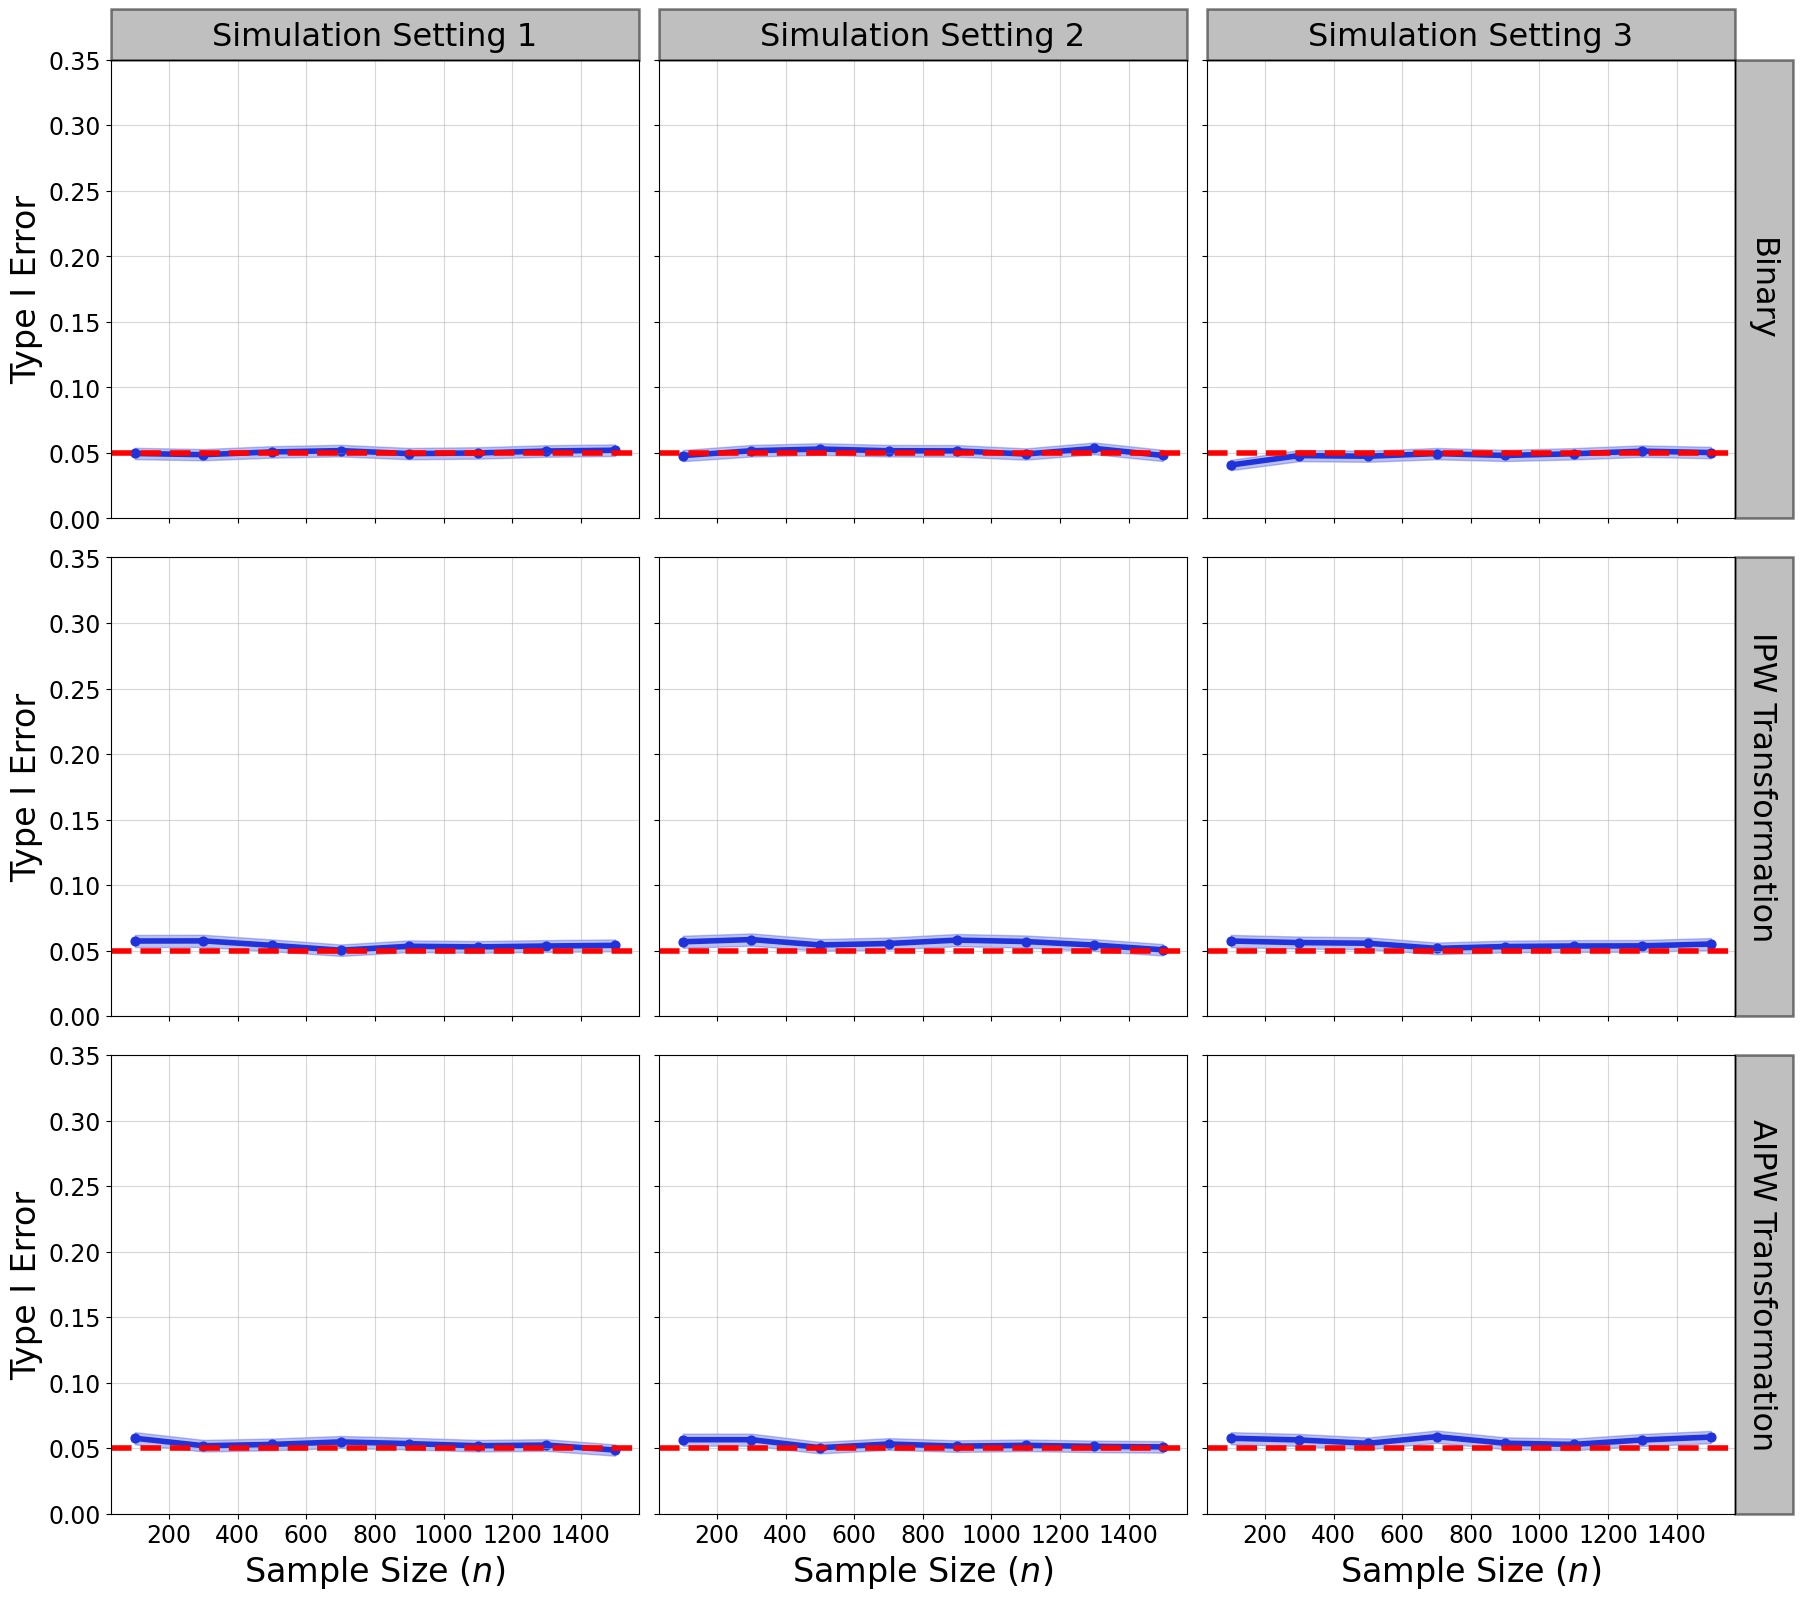

In [8]:
fig, ax = plt.subplots(3,3,figsize=(18,16), sharex=True, sharey=True)

PLOT_SAVELABEL = "type1_error"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER // 3
AX1 = PANEL_COUNTER % 3

for binary, transform_type in binary_transform_type_space:
    sub_res_df = agg_res_df
    # Subset to the right row
    sub_res_df = sub_res_df[sub_res_df.binary == binary]
    sub_res_df = sub_res_df[sub_res_df.SPECIAL_TOKEN_NULLDGPS_TRANSFORM_TYPE == transform_type]
    for d in d_space:
        # Subset to the right column
        # Note that all columns align with d
        sub_sub_res_df = sub_res_df[sub_res_df.d == d]
        # Plot
        n_viz = sub_sub_res_df.n.values
        t1e_viz = sub_sub_res_df.rejected_mean.values
        t1e_se_viz = sub_sub_res_df.rejected_se.values
        ax[AX0, AX1].plot(n_viz, t1e_viz, color=method_cmap[("Chiseling", 1)],
                          label=legend_mapper[(binary, transform_type, d)],
                          linewidth=LINEWIDTH)
        ax[AX0, AX1].scatter(n_viz, t1e_viz, color=method_cmap[("Chiseling", 1)], s=MARKERSIZE)
        ax[AX0, AX1].fill_between(n_viz,
                                  t1e_viz - 2 * t1e_se_viz,
                                  t1e_viz + 2 * t1e_se_viz,
                                  color=method_cmap[("Chiseling", 1)],
                                  alpha=0.3)
        # Add line for alpha
        ax[AX0, AX1].axhline(alpha, color="red", linestyle="--", linewidth=LINEWIDTH)
        # Set ylim
        ax[AX0, AX1].set_ylim(0,0.35)
        # Hide the right and top spines
        ax[AX0, AX1].grid(visible=True, alpha=0.5)
        # Increment panel coordinates
        PANEL_COUNTER += 1
        AX0 = PANEL_COUNTER // 3
        AX1 = PANEL_COUNTER % 3

# y-labels
ax[0,0].set_ylabel("Type I Error", fontsize=LABEL_FONTSIZE)
ax[1,0].set_ylabel("Type I Error", fontsize=LABEL_FONTSIZE)
ax[2,0].set_ylabel("Type I Error", fontsize=LABEL_FONTSIZE)

# x-labels
for i in range(3):
    ax[2,i].set_xlabel("Sample Size ($n$)", fontsize=LABEL_FONTSIZE)

# Tick fontsize
ax[0,0].tick_params(axis="y", labelsize=TICK_FONTSIZE)
ax[1,0].tick_params(axis="y", labelsize=TICK_FONTSIZE)
ax[2,0].tick_params(axis="y", labelsize=TICK_FONTSIZE)
ax[2,0].tick_params(axis="x", labelsize=TICK_FONTSIZE)
ax[2,1].tick_params(axis="x", labelsize=TICK_FONTSIZE)
ax[2,2].tick_params(axis="x", labelsize=TICK_FONTSIZE)

# Add top label
for i, top_label in enumerate(["Simulation Setting 1", "Simulation Setting 2", "Simulation Setting 3"]):
    strip = mpatches.FancyBboxPatch(
        (0.05, 1.05), # Start positions
        0.9, 0.01, # width & height (fraction of axes)
        transform=ax[0,i].transAxes,
        boxstyle="square,pad=0.05",
        facecolor=FACET_FACECOLOR,
        alpha=FACET_FACEALPHA,
        linewidth=FACET_LINEWIDTH,
        clip_on=False, zorder=2
    )
    ax[0,i].add_patch(strip)
    # centred label inside the strip
    ax[0,i].text(0.5, 1.05, top_label,
                 ha="center", va="center",
                 transform=ax[0,i].transAxes,
                 fontsize=FACET_FONTSIZE, color=FACET_TEXTCOLOR)

# Add right-label
for i, right_label in enumerate(["Binary", "IPW Transformation", "AIPW Transformation"]):
    strip = mpatches.FancyBboxPatch(
        (1.05, 0.05), # Start positions
        0.01, 0.9, # width & height (fraction of axes)
        transform=ax[i,-1].transAxes,
        boxstyle="square,pad=0.05",
        facecolor=FACET_FACECOLOR,
        alpha=FACET_FACEALPHA,
        linewidth=FACET_LINEWIDTH,
        clip_on=False, zorder=2
    )
    ax[i,-1].add_patch(strip)
    # centred label inside the strip
    ax[i,-1].text(1.05, 0.5, right_label,
                  ha="center", va="center",
                  rotation=-90,
                  transform=ax[i,-1].transAxes,
                  fontsize=FACET_FONTSIZE, color=FACET_TEXTCOLOR)

plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()